In [4]:
!pip -q install -U diffusers transformers datasets accelerate safetensors pillow
!pip -q install --force-reinstall "pillow<12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 135.4 MB/s eta 0:00:00


In [5]:
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
from PIL import Image, ImageOps

from transformers import CLIPTokenizer, CLIPTextModel
from diffusers.models import AutoencoderKL

device = "cuda"
torch.backends.cuda.matmul.allow_tf32 = True

# 1) Text encoder (Transformer)
TEXT_MODEL = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(TEXT_MODEL)
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL).to(device).eval()
for p in text_encoder.parameters():
    p.requires_grad = False

# 2) VAE
VAE_MODEL = "stabilityai/sd-vae-ft-mse"
vae = AutoencoderKL.from_pretrained(VAE_MODEL).to(device).eval()
for p in vae.parameters():
    p.requires_grad = False

scaling_factor = getattr(vae.config, "scaling_factor", 0.18215)  # 보통 0.18215 :contentReference[oaicite:3]{index=3}
print("text hidden:", text_encoder.config.hidden_size, "vae scaling_factor:", scaling_factor)


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

text hidden: 512 vae scaling_factor: 0.18215


In [10]:
from datasets import load_dataset
from torch.utils.data import IterableDataset, DataLoader

SEED = 42
torch.manual_seed(SEED)

def pil_to_tensor_512(pil):
    pil = pil.convert("RGB")
    pil = ImageOps.fit(pil, (512, 512), method=Image.BICUBIC)  # resize+center crop
    arr = np.array(pil).astype(np.float32) / 255.0
    x = torch.from_numpy(arr).permute(2,0,1)  # (3,512,512)
    x = x * 2.0 - 1.0  # [-1,1]
    return x

class CocoStream(IterableDataset):
    def __init__(self, split="test", streaming=True):  # test(40.7k) / val(5k)
        self.ds = load_dataset("lmms-lab/COCO-Caption2017", split=split, streaming=streaming)
        if streaming:
            self.ds = self.ds.shuffle(buffer_size=500, seed=SEED)

    def __iter__(self):
        for ex in self.ds:
            caps = ex["answer"]          # <- captions 리스트(5개)
            cap = caps[np.random.randint(0, len(caps))]
            img = pil_to_tensor_512(ex["image"])
            yield {"pixel_values": img, "caption": cap}

def collate(batch):
    images = torch.stack([b["pixel_values"] for b in batch])
    captions = [b["caption"] for b in batch]
    tok = tokenizer(
        captions,
        padding="max_length",
        truncation=True,
        max_length=77,   # CLIP 표준 길이
        return_tensors="pt"
    )
    return {
        "pixel_values": images,
        "input_ids": tok.input_ids,
        "attention_mask": tok.attention_mask
    }

BATCH = 16  # L4면 16~32 사이로 시작
train_ds = CocoStream(split="test", streaming=True)
train_loader = DataLoader(train_ds, batch_size=BATCH, num_workers=0, collate_fn=collate)


In [11]:
class TextToLatentMapper(nn.Module):
    def __init__(self, d_text, base_ch=256):
        super().__init__()
        # 간단하게: 토큰 평균 풀링 -> 벡터 -> (256, 8, 8)로 만든 뒤 업샘플
        self.fc = nn.Sequential(
            nn.LayerNorm(d_text),
            nn.Linear(d_text, base_ch * 8 * 8),
            nn.GELU(),
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(base_ch, base_ch//2, 4, 2, 1), nn.GELU(),  # 8->16
            nn.ConvTranspose2d(base_ch//2, base_ch//4, 4, 2, 1), nn.GELU(),# 16->32
            nn.ConvTranspose2d(base_ch//4, base_ch//8, 4, 2, 1), nn.GELU(),# 32->64
            nn.Conv2d(base_ch//8, 4, 3, 1, 1),
        )

    def forward(self, last_hidden_state, attention_mask):
        # mean pooling (mask 반영)
        mask = attention_mask.unsqueeze(-1).float()  # (B,77,1)
        x = (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1.0)  # (B,D)
        x = self.fc(x).view(x.size(0), -1, 8, 8)  # (B,256,8,8)
        z = self.up(x)  # (B,4,64,64)
        return z

mapper = TextToLatentMapper(text_encoder.config.hidden_size).to(device)
opt = torch.optim.AdamW(mapper.parameters(), lr=2e-4, weight_decay=1e-2)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-3360553156.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
from tqdm.auto import tqdm

MAX_STEPS = 2000 
LOG_EVERY = 50

mapper.train()
it = iter(train_loader)

pbar = tqdm(range(1, MAX_STEPS+1))
for step in pbar:
    batch = next(it)
    images = batch["pixel_values"].to(device)
    input_ids = batch["input_ids"].to(device)
    attn = batch["attention_mask"].to(device)

    with torch.no_grad():
        txt = text_encoder(input_ids=input_ids, attention_mask=attn).last_hidden_state  # (B,77,D)
        # VAE latent target (deterministic)
        z_tgt = vae.encode(images).latent_dist.mean * scaling_factor  # (B,4,64,64)

    opt.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast():
        z_pred = mapper(txt, attn)
        loss = F.mse_loss(z_pred, z_tgt)

    scaler.scale(loss).backward()
    scaler.step(opt)
    scaler.update()

    if step % LOG_EVERY == 0:
        pbar.set_postfix(loss=float(loss.detach().cpu()))

  0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipython-input-450682992.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


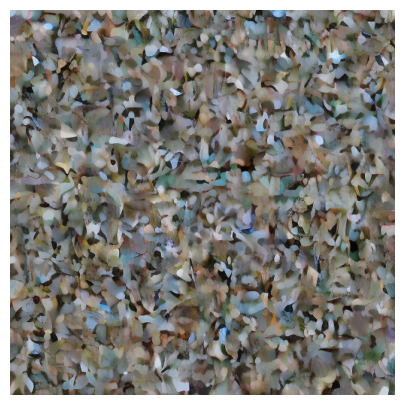

In [18]:
import matplotlib.pyplot as plt

@torch.no_grad()
def decode_latents(z):
    imgs = vae.decode(z / scaling_factor).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)  # [0,1]
    return imgs

@torch.no_grad()
def generate(prompt, noise_scale=0.3):
    tok = tokenizer(prompt, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
    input_ids = tok.input_ids.to(device)
    attn = tok.attention_mask.to(device)

    txt = text_encoder(input_ids=input_ids, attention_mask=attn).last_hidden_state
    z = mapper(txt, attn)
    z = z + noise_scale * torch.randn_like(z)  # 다양성용 노이즈(선택)
    img = decode_latents(z)[0].permute(1,2,0).cpu().numpy()
    return img

mapper.eval()
img = generate("a simple cute robot, flat illustration, white background", noise_scale=0.5)
plt.figure(figsize=(5,5)); plt.imshow(img); plt.axis("off"); plt.show()